# Applied Capstone Project - Final Assignment
We'll start by installing the necessary packages and importing a few libraries

In [1]:
!conda install -c conda-forge geopy --yes 
!conda install -c conda-forge folium=0.5.0 --yes 
#!conda install shapely --yes
!conda install -c conda-forge eli5 --yes
!conda install -c conda-forge shap --yes
!conda install -c conda-forge xgboost --yes

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00   1.01 MB/s
geopy-1.17.0-p 100% |################################| Time: 0:00:00   1.54 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.0-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   2.77 MB/s
branca-0.3.0-p 100% |################################| Time: 0:00:00  16.35 MB/s
vincent-0.4.4- 100% |###################

In [2]:
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
import pandas as pd
import numpy as np

I'll hide the next cell because it contains my FourSquare credentials

In [3]:
# The code was removed by Watson Studio for sharing.

Let's test that we can get some FourSquare data

In [4]:
lat = 43.679882
lng = -79.544266

In [5]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

In [6]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5bce02af9fb6b75291665634'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4ff1dbf1e4b07cca845d6e91-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/juicebar_',
          'suffix': '.png'},
         'id': '52f2ab2ebcbc57f1066b8b41',
         'name': 'Smoothie Shop',
         'pluralName': 'Smoothie Shops',
         'primary': True,
         'shortName': 'Smoothie Shop'}],
       'id': '4ff1dbf1e4b07cca845d6e91',
       'location': {'address': '265 Wincott Drive, Unit 2A',
        'cc': 'CA',
        'city': 'Etobicoke',
        'country': 'Canada',
        'distance': 56,
        'formattedAddress': ['265 Wincott Drive, Unit 2A',
         'Etobicoke ON M9R 2R7',
         'Canada'],
        'labeledLatLngs': [{'label': 'display',


The next cell contains my IBM Cloud Object Storage credentials, so I will hide it as well

In [7]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,Address,AreaName,Price ($),lat,lng
0,0,"86 Waterford Dr Toronto, ON",Richview,999888,43.679882,-79.544266
1,1,"#80 - 100 BEDDOE DR Hamilton, ON",Chedoke Park B,399900,43.250000,-79.904396
2,2,"213 Bowman Street Hamilton, ON",Ainslie Wood East,479000,43.251690,-79.919357
3,3,"102 NEIL Avenue Hamilton, ON",Greenford,285900,43.227161,-79.767403
4,6,"#1409 - 230 King St Toronto, ON",Downtown,362000,43.651478,-79.368118


In [8]:
prices=df_data_1

I'll clean up the data set format a bit and check the data types for any weirdness

In [9]:
prices.drop('Unnamed: 0',axis=1, inplace=True)
prices.rename(columns={'Price ($)':'Price'},inplace=True)

In [10]:
prices.dtypes

Address      object
AreaName     object
Price         int64
lat         float64
lng         float64
dtype: object

Great! All fields are of the expected data types. Next step is to look at the data for missing and other problematic values.

In [11]:
prices.describe(include='all')

,Address,AreaName,Price,lat,lng
count,25351,24868,2.535100e+04,25351.000000,25351.000000
unique,23594,1119,NaN,NaN,NaN
top,"223 Erb Street Waterloo, ON",Downtown,NaN,NaN,NaN
freq,16,830,NaN,NaN,NaN
mean,NaN,NaN,5.645438e+05,37.326614,-85.218379
std,NaN,NaN,8.475962e+05,82.858347,73.093572
min,NaN,NaN,0.000000e+00,-999.000000,-999.000000
25%,NaN,NaN,2.199000e+05,43.401087,-80.308159
50%,NaN,NaN,3.719000e+05,43.715977,-79.503342
75%,NaN,NaN,6.199000e+05,44.466711,-79.107326


I see a number of problems above:
* Some entries are missing the area name
* Minimum of price is zero. Were those properties given away for free?
* Some entries seem to have latitude and/or longitude set to -999. That's invalid.
* Still looking at latitudes and longitudes, it seems the data set is bigger than just Toronto
* Longitude = 1.074519 is not even in North America!
* Looks like there are some duplicates in the data

I decided not to do anything about the area names (I may not even use this feature), but the others need fixing

In [12]:
# price = 0 is suspicious. Let's do a histogram.
import seaborn as sns
prices[['Price']].hist(xlabelsize=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f254eb7bf98>]], dtype=object)

Hummm... That didn't tell me much. Let's try a distribution plot, and let's exclude the very high values to see a more representative portion of the data.

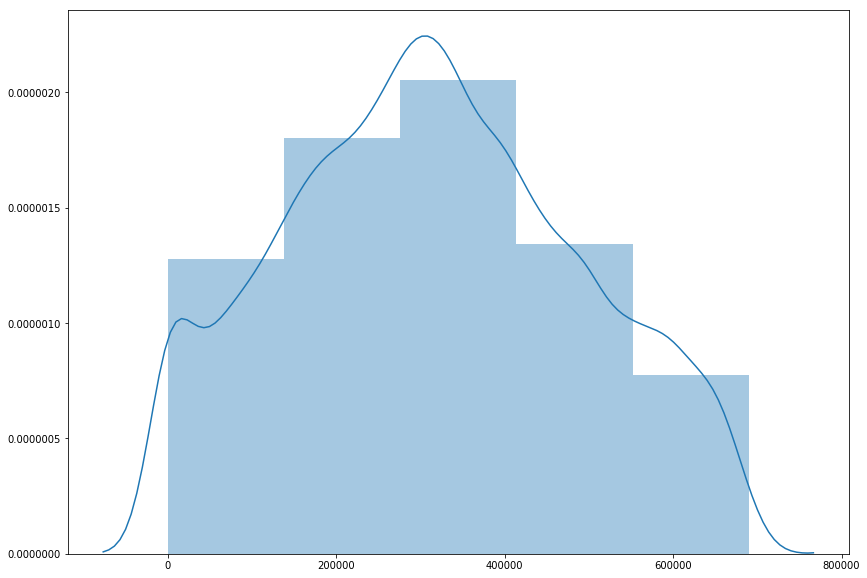

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(14,10))
sns.distplot(sorted(prices['Price'])[:20000],ax=ax,bins=5)

OK, it looks like we have lots of very small values that we need to get rid of. Let's confirm with a few more plots.

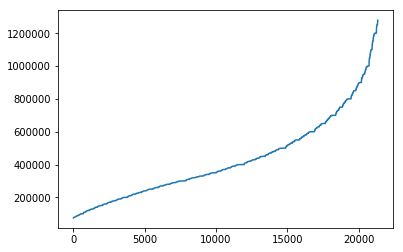

In [14]:
plt.plot(sorted(prices['Price'])[2000:-2000])

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


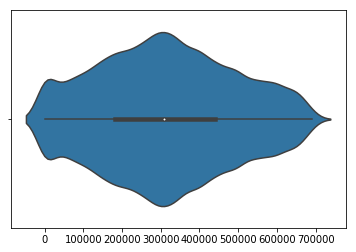

In [15]:
sns.violinplot(x=sorted(prices['Price'])[:20000])

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


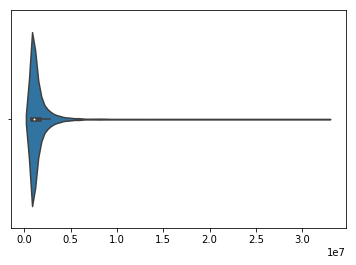

In [16]:
sns.violinplot(x=sorted(prices['Price'])[20000:])

Yep, we have lots of outliers, at both ranges of the spectrum. Let's get rid of the top and bottom 1000 values to eliminate those.

In [17]:
prices=prices.sort_values(by='Price',axis=0)[1000:-1000]

Next step is to get rid of those invalide latitudes.

In [18]:
prices[prices['lat']<=-900]

,Address,AreaName,Price,lat,lng
2868,"230 Maggie St Municipality Of Arran-elderslie, ON",NaN,23000,-999.0,-999.0
14773,"17424 MCFAIL ROAD UNKN, ON",NaN,25000,-999.0,-999.0
18780,"22 LAKECREST Circle BRIGHTON TWP, ON",NaN,32000,-999.0,-999.0
22220,"19 Snowbird Drive Hastings, ON",NaN,39000,-999.0,-999.0
3452,"597374 GREY ROAD 29 Sydenham Twp, ON",NaN,39900,-999.0,-999.0
3696,"597364 GREY ROAD 29 Sydenham Twp, ON",NaN,39900,-999.0,-999.0
4231,"LT 24 Glen Fiddish Rd Glenelg, ON",NaN,45000,-999.0,-999.0
3010,"14 BLUE JAY BROCKTON, ON",NaN,49900,-999.0,-999.0
3231,"395 PETER&#39;S Road CRAMAHE TWP, ON",NaN,54900,-999.0,-999.0
7513,"PART 2 Lorne Beach Rd Kincardine Twp, ON",NaN,54900,-999.0,-999.0


In [19]:
prices=prices[prices['lat']>-900]
prices.shape

(23198, 5)

And of the duplicate entries...

In [20]:
prices.drop_duplicates(inplace=True)

In [21]:
prices.shape

(22446, 5)

In [22]:
prices.describe()

,Price,lat,lng
count,2.244600e+04,22446.000000,22446.000000
mean,4.587407e+05,43.977574,-79.335055
std,3.370937e+05,1.022859,2.396276
min,1.990000e+04,36.160065,-122.553154
25%,2.349000e+05,43.432420,-80.277733
50%,3.699000e+05,43.730101,-79.480339
75%,5.899000e+05,44.526489,-79.051740
max,1.899000e+06,53.851017,-0.163367


That looks better! OK, we still have entries from all over Ontario. Let's focus on Toronto.

In [23]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="coursera-capstone-project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Let's look at how far the first record is from Toronto:

In [24]:
import geopy.distance as gd
coords_1 = (latitude,longitude)
coords_2 = (prices.iloc[1].lat,prices.iloc[0].lng)
gd.vincenty(coords_1, coords_2).km 

164.00620421512778

Definitely too far! Let's do some more cleaning, and add a distance feature to our data set.

In [25]:
prices=prices.reset_index().drop('index', axis=1)

In [26]:
prices.head()

,Address,AreaName,Price,lat,lng
0,"PART LOT 23 MAPLE DR Miller Lake, ON",Miller Lake,19900,45.077942,-81.419052
1,"19 ALBERT ST Clinton, ON",Clinton,19900,43.617508,-81.539467
2,"865 YORK MILLS RD Toronto, ON",Don Mills,19900,43.754169,-79.349495
3,on Silver Street on Silver Street Mount Forest...,Mount Forest,19900,43.967819,-80.740112
4,"LOT 46 WALKER RD Thessalon, ON",NaN,19900,46.281830,-83.495140


In [27]:
# Let's use a 20 km radius from Toronto (source: https://en.wikipedia.org/wiki/Toronto)
prices['dist'] = prices.apply(lambda prices: gd.vincenty(coords_1, (prices['lat'],prices['lng'])).km, axis = 1)

In [28]:
prices.head(20)

,Address,AreaName,Price,lat,lng,dist
0,"PART LOT 23 MAPLE DR Miller Lake, ON",Miller Lake,19900,45.077942,-81.419052,226.411631
1,"19 ALBERT ST Clinton, ON",Clinton,19900,43.617508,-81.539467,173.719556
2,"865 YORK MILLS RD Toronto, ON",Don Mills,19900,43.754169,-79.349495,11.541037
3,on Silver Street on Silver Street Mount Forest...,Mount Forest,19900,43.967819,-80.740112,114.303063
4,"LOT 46 WALKER RD Thessalon, ON",NaN,19900,46.281830,-83.495140,436.138479
5,"PART 3 ROSEDALE AVE Elk Lake, ON",Elk Lake,19900,47.730717,-80.326263,458.967535
6,"1063 Burney Pt Central Frontenac, ON",Sharbot Lake,19900,44.784199,-76.711700,247.938411
7,"128 HARKNESS ST Nipigon, ON",Nipigon,19900,49.011974,-88.271080,905.906587
8,"6 BENNETT Street Bruce Mines, ON",Bruce Mines,19900,46.301392,-83.797424,455.473466
9,"4242 MELIA DR Mississauga, ON",Mississauga,19999,43.570236,-79.673409,24.906603


In [29]:
prices=prices[prices['dist']<=20]
prices.head()

,Address,AreaName,Price,lat,lng,dist
2,"865 YORK MILLS RD Toronto, ON",Don Mills,19900,43.754169,-79.349495,11.541037
12,"55 Regent Park Blvd Toronto, ON",Downtown,20000,43.659454,-79.360992,2.200935
14,"2620 EGLINTON AVE E Toronto, ON",Eglinton East,20000,43.735878,-79.252121,14.192507
22,"30 EASTWOOD RD Toronto, ON",Beach Hill,20000,43.673386,-79.318268,5.964549
23,"#328 - 4438 SHEPPARD AVE E Toronto, ON",Agincourt,20000,43.788311,-79.268082,17.747087


In [30]:
prices.shape

(4493, 6)

Looks like the data is finally ready! 

In [31]:
prices.describe()

,Price,lat,lng,dist
count,4.493000e+03,4493.000000,4493.000000,4493.000000
mean,5.495195e+05,43.700104,-79.410462,9.637398
std,3.532288e+05,0.059841,0.092094,6.022377
min,1.990000e+04,43.548615,-79.632446,0.082268
25%,3.250000e+05,43.647514,-79.475639,3.230831
50%,4.570000e+05,43.688763,-79.400894,10.522263
75%,6.990000e+05,43.758404,-79.363922,14.550097
max,1.899000e+06,43.832329,-79.191078,19.988797


Time to get nearby venues from FourSquare. We'll reuse the function from the lab.

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Address Latitude', 
                  'Address Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's define "comfortable walking distance" as **200 m**. Also, given the limited number of calls available for my free FourSquare account, let's use a sample of just **200** sales

In [33]:
radius = 200
LIMIT = 100
import random
random.seed=0
sample_prices=prices.iloc[random.sample(range(prices.shape[0]), 200)]
sample_prices.head()

,Address,AreaName,Price,lat,lng,dist
11956,"#303 - 256 DORIS AVE Toronto, ON",Willowdale,394800,43.771595,-79.412178,13.223727
9092,"#1101 - 225 SACKVILLE ST E Toronto, ON",Downtown,319800,43.659824,-79.362724,2.079555
13609,"#2905 - 21 WIDMER ST Toronto, ON",Downtown,445000,43.647224,-79.391098,0.811880
6513,"250 Ferrand Dr Toronto, ON",Flemingdon Park,259000,43.719769,-79.331573,8.577752
1242,"646 College St Toronto, ON",Little Italy,89000,43.655136,-79.415962,2.323327


We'll plot our samples on the map, to make sure their distribution is not too bad

In [34]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, address, price in zip(sample_prices['lat'], sample_prices['lng'], sample_prices['Address'], sample_prices['Price']):
    label = '{}: {}'.format(address, price)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    
map_toronto

In [35]:
toronto_venues = getNearbyVenues(sample_prices['Address'], sample_prices['lat'], sample_prices['lng'])
toronto_venues.head()

#303 - 256 DORIS AVE Toronto, ON
#1101 - 225 SACKVILLE ST E Toronto, ON
#2905 - 21 WIDMER ST Toronto, ON
250 Ferrand Dr Toronto, ON
646 College St Toronto, ON
#1608 - 101 PRUDENTIAL DR Toronto, ON
2714 St. Clair Ave Toronto, ON
#805 - 155 Yorkville Ave Toronto, ON
#F1 - 55 AVENUE RD Toronto, ON
43B Foch Ave Toronto, ON
157 Linden Ave Toronto, ON
#108 - 275 BAMBURGH CIRC Toronto, ON
1249 Warden Ave Toronto, ON
#309 - 100 LEEWARD GLWY Toronto, ON
#1406 - 80 MARINE PARADE DR Toronto, ON
#1020 - 39 Queens Quay Toronto, ON
#912 - 2737 KEELE ST Toronto, ON
#714 - 68 MERTON ST Toronto, ON
1093 Dundas St Toronto, ON
#Ph04 - 5229 Dundas St Toronto, ON
#332 - 665 KENNEDY RD Toronto, ON
42 SEACLIFF BLVD Toronto, ON
#2 - 671 HUNTINGWOOD DR Toronto, ON
3103 KINGSTON RD Toronto, ON
#602 - 28 EMPRESS AVE Toronto, ON
#122 - 4765 Jane St Toronto, ON
#2003 - 1 THE ESPLANADE Toronto, ON
651 College St Toronto, ON
#4 - 375 Cook Rd Toronto, ON
#105 - 260 SCARLETT RD Toronto, ON
#1006 - 20 Bloorview Pl Toro

,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,The Captain's Boil,43.773255,-79.413805,Seafood Restaurant
1,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Burrito Boyz,43.773054,-79.414082,Burrito Place
2,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Dakgogi,43.773010,-79.413875,Korean Restaurant
3,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,St. Louis Bar & Grill,43.773040,-79.413771,Wings Joint
4,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Aroma Espresso Bar,43.769449,-79.413081,Café


In [36]:
print('Shape: ', toronto_venues.shape)
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

Shape:  (6584, 7)
There are 318 unique categories.


Even with just 200 samples, we got a lot of venues!

In [37]:
toronto_venues.rename(columns={'Neighborhood':'Address', 'Neighborhood Latitude':'Address Latitude', 'Neighborhood Longitude':'Address Longitude'}, inplace=True)

In [38]:
toronto_venues.head()

,Address,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,The Captain's Boil,43.773255,-79.413805,Seafood Restaurant
1,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Burrito Boyz,43.773054,-79.414082,Burrito Place
2,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Dakgogi,43.773010,-79.413875,Korean Restaurant
3,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,St. Louis Bar & Grill,43.773040,-79.413771,Wings Joint
4,"#303 - 256 DORIS AVE Toronto, ON",43.771595,-79.412178,Aroma Espresso Bar,43.769449,-79.413081,Café


In [39]:
toronto_venues.groupby('Address').count()

,Address Latitude,Address Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Address,,,,,,
"##1 - 45 Overlea Blvd Toronto, ON",25,25,25,25,25,25
"#1 A - 317 LONSDALE RD Toronto, ON",24,24,24,24,24,24
"#1001 - 5162 Yonge St Toronto, ON",51,51,51,51,51,51
"#1002 - 3 MARINE PARADE DR Toronto, ON",19,19,19,19,19,19
"#1002 - 3 Marine Parade Dr Toronto, ON",19,19,19,19,19,19
"#1006 - 20 Bloorview Pl Toronto, ON",2,2,2,2,2,2
"#1008 - 38 The Esplanade St Toronto, ON",100,100,100,100,100,100
"#101 - 10 Scollard St Toronto, ON",98,98,98,98,98,98
"#1015 - 101 PETER ST Toronto, ON",100,100,100,100,100,100


A couple of rows with missing values (no venues) - let's drop those too

In [40]:
toronto_venues.dropna(inplace=True)

Looks like some addresses have no venues nearby, but that still OK. Let's one-hot encode our features now:

In [41]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Address'] = toronto_venues['Address'] 

# move neighborhood column to the first column
toronto_onehot=toronto_onehot.set_index('Address').reset_index()

toronto_onehot.head()


,Address,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"#303 - 256 DORIS AVE Toronto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"#303 - 256 DORIS AVE Toronto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"#303 - 256 DORIS AVE Toronto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"#303 - 256 DORIS AVE Toronto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,"#303 - 256 DORIS AVE Toronto, ON",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
toronto_onehot.shape

(6584, 319)

In [43]:
toronto_grouped = toronto_onehot.groupby('Address').mean().reset_index()
toronto_grouped.head()

,Address,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"##1 - 45 Overlea Blvd Toronto, ON",0.0,0.0,0.08,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.04,0.0,0.0,0.0,0.000000,0.04,0.04
1,"#1 A - 317 LONSDALE RD Toronto, ON",0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
2,"#1001 - 5162 Yonge St Toronto, ON",0.0,0.0,0.00,0.0,0.019608,0.0,0.0,0.0,0.0,...,0.0,0.019608,0.0,0.00,0.0,0.0,0.0,0.019608,0.00,0.00
3,"#1002 - 3 MARINE PARADE DR Toronto, ON",0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00
4,"#1002 - 3 Marine Parade Dr Toronto, ON",0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.00


In [44]:
toronto_grouped.shape

(198, 319)

Next step is to get a final set for analysis:

In [45]:
# Let's merge with the original sample set
toronto_merged = sample_prices

# merge toronto_grouped to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_grouped.set_index('Address'), on='Address')

toronto_merged.head()

,Address,AreaName,Price,lat,lng,dist,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,...,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
11956,"#303 - 256 DORIS AVE Toronto, ON",Willowdale,394800,43.771595,-79.412178,13.223727,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.00
9092,"#1101 - 225 SACKVILLE ST E Toronto, ON",Downtown,319800,43.659824,-79.362724,2.079555,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
13609,"#2905 - 21 WIDMER ST Toronto, ON",Downtown,445000,43.647224,-79.391098,0.811880,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.02
6513,"250 Ferrand Dr Toronto, ON",Flemingdon Park,259000,43.719769,-79.331573,8.577752,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
1242,"646 College St Toronto, ON",Little Italy,89000,43.655136,-79.415962,2.323327,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.015873,0.0,0.00


In [46]:
toronto_merged.shape

(200, 324)

Time to get rid of those empty rows:

In [47]:
toronto_merged.dropna(inplace=True)

In [48]:
# Now let's do a multivariate linear regression
target=toronto_merged['Price']
features = toronto_merged.iloc[:,6:]

In [49]:
features.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,...,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
11956,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.00
9092,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
13609,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.01,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.02
6513,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00
1242,0.0,0.0,0.0,0.0,0.031746,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.015873,0.0,0.00


For this project, I used a Linear Regression. 

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

train_X, val_X, train_y, val_y = train_test_split(features, target, random_state=0)
my_model = LinearRegression().fit(train_X, train_y)

In [51]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(my_model, features, target, cv=10)

In [52]:
scores

array([ -1.15753783e+25,  -2.36455525e+25,  -1.52132382e+23,
        -5.22387005e+23,  -5.15538595e+24,  -8.37011844e+24,
        -3.50960488e+25,  -1.09476564e+25,  -7.18352577e+24,
        -1.06368784e+23])

In [53]:
print("The mean of the folds are", scores.mean(),"and the standard deviation is" ,scores.std())

The mean of the folds are -1.02754554371e+25 and the standard deviation is 1.06648150055e+25


That's horrible!

For the sake of experiment, let's still look at the most important features, and how they affect the model.

In [54]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
2325493595060266845863936.0000 ± 1402036432212851578372096.0000,Pool
1825866146590592696582144.0000 ± 1170356118481127037992960.0000,Beach
1698861875605457260773376.0000 ± 2968352497824441556795392.0000,Park
1619813982321988465590272.0000 ± 2929239131751025018404864.0000,Coffee Shop
1398720304526151433322496.0000 ± 4998856642315279189147648.0000,Aquarium
1359665191800198741884928.0000 ± 1010265398436353806434304.0000,Bar
822242832066212165320704.0000 ± 2488754526953991837843456.0000,Steakhouse
786636178248017354162176.0000 ± 1071489516253774627209216.0000,Liquor Store
749456744497334041182208.0000 ± 1185045747413602826977280.0000,Gym / Fitness Center
737626172567164347744256.0000 ± 324536858439465866100736.0000,Mexican Restaurant


In [55]:
feature_importances = pd.DataFrame(features.columns, columns=['Feature'])
feature_importances['Importance'] = perm.feature_importances_ 
feature_importances.sort_values(by='Importance',axis=0)[-20:]

,Feature,Importance
118,Frozen Yogurt Shop,4.262950e+23
227,Pet Store,4.509987e+23
116,French Restaurant,4.648196e+23
77,Construction & Landscaping,4.941885e+23
20,Bank,5.041985e+23
119,Furniture / Home Store,5.201778e+23
79,Cosmetics Shop,5.731915e+23
53,Café,6.731661e+23
84,Deli / Bodega,7.032410e+23
23,Baseball Stadium,7.362362e+23


In [56]:
top_features=feature_importances.sort_values(by='Importance',axis=0)[-20:].drop('Importance', axis=1)
top_features = sum(top_features.values.tolist(),[])
top_features

['Frozen Yogurt Shop',
 'Pet Store',
 'French Restaurant',
 'Construction & Landscaping',
 'Bank',
 'Furniture / Home Store',
 'Cosmetics Shop',
 'Café',
 'Deli / Bodega',
 'Baseball Stadium',
 'Mexican Restaurant',
 'Gym / Fitness Center',
 'Liquor Store',
 'Steakhouse',
 'Bar',
 'Aquarium',
 'Coffee Shop',
 'Park',
 'Beach',
 'Pool']

In [57]:
simple_model = LinearRegression().fit(train_X[top_features], train_y)

In [58]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(simple_model, features[top_features], target, cv=10,scoring='r2')
scores

array([ 0.21994697, -0.4724802 , -0.35847069,  0.11728712, -0.2194397 ,
       -0.17321   ,  0.07067684,  0.17455399,  0.14227431, -0.23867834])

In [59]:
print("The mean of the folds are", scores.mean(),"and the standard deviation is" ,scores.std())

The mean of the folds are -0.0737539705303 and the standard deviation is 0.234585669886


Still bad, but moving in the right direction. I will stop here, though.

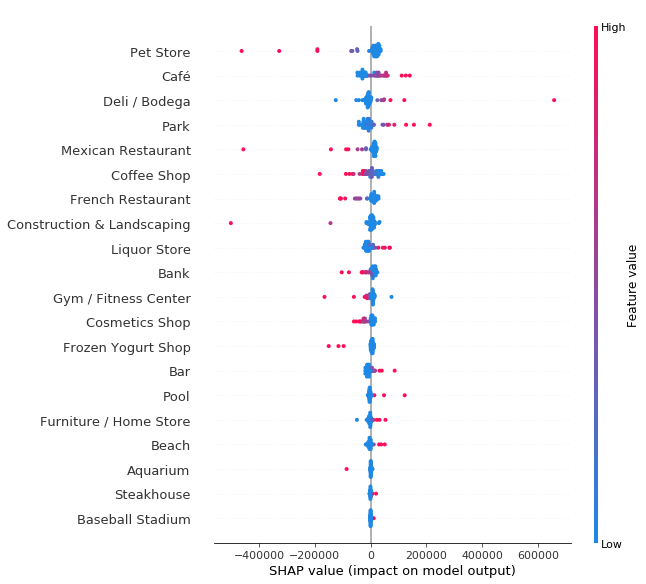

In [60]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.LinearExplainer(simple_model,features[top_features])

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X[top_features])

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, val_X[top_features])